# Ejercicio 6 - guía 4

Se le propone a un grupo de niños y niñas una actividad: construir torres lo más altas posible usando bloques cúbicos y cilíndricos. 
Se registran en https://github.com/franciscokordon/estainferencia/blob/main/data/blocks.csv las edades de los infantes, el número de bloques y el
tiempo empleado. En este problema, solo consideramos el número de bloques utilizados y las edades.

## a)
Graficar el número de bloques 𝑦 vs las edades 𝑥. A partir del gráfico, proponer un MLG.

### Desarrollo

Primero cargo los datos:

In [1]:
import pandas as pd
import os

ruta_datos_torres = os.path.join('..', '..','datos', 'raw' ,'blocks.csv')

df_torres = pd.read_csv(ruta_datos_torres, index_col=0)

df_torres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Child   100 non-null    object 
 1   Number  100 non-null    int64  
 2   Time    100 non-null    float64
 3   Trial   100 non-null    int64  
 4   Shape   100 non-null    object 
 5   Age     100 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 5.5+ KB


Analizo como se distribuyen las variables que se verán implicadas en la estimación:

Text(0.5, 0, 'Number')

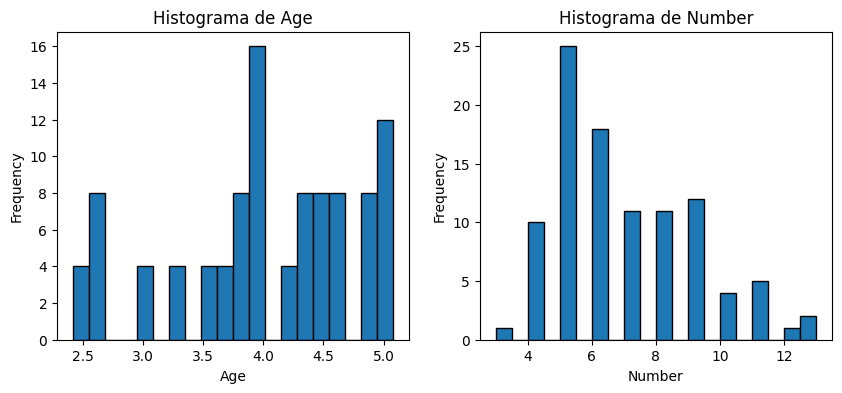

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# en el primer eje hago un histograma de la variable "Age"
df_torres['Age'].plot.hist(ax=ax[0], bins=20, edgecolor='black')
ax[0].set_title('Histograma de Age')
ax[0].set_xlabel('Age')

# en el segundo eje hago un histograma de la variable "Number"
df_torres['Number'].plot.hist(ax=ax[1], bins=20, edgecolor='black')
ax[1].set_title('Histograma de Number')
ax[1].set_xlabel('Number')

Y ahora grafico las edades de los niños vs el número de bloques usados:

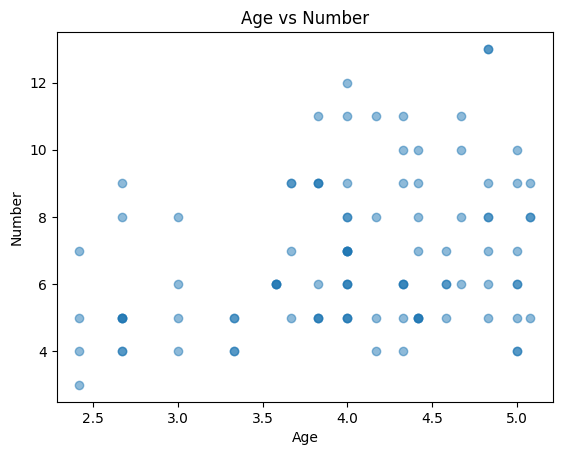

In [3]:
plt.scatter(df_torres['Age'], df_torres['Number'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Number')
plt.title('Age vs Number')
plt.show()

Ya que a partir del gráfico no se me ocurre proponer ningún MLG, paso a analizar la relación varianza-media de los datos observados, para así tener una ídea más sólida sobre cual modelo puedo elegir:

In [4]:
# Separo el df en 5 grupos de acuerdo a la edad
df_torres['age_cut'] = pd.cut(df_torres['Age'], bins=5)

# Calculo la media y varianza de cada grupo
df_agrupado = df_torres.groupby('age_cut')['Number']
medias = df_agrupado.mean()
varianzas = df_agrupado.var()
longitudes = df_agrupado.size()

# Muestro el resultado en formato de tabla
df_resultado = pd.DataFrame({'Media': medias, 'Varianza': varianzas, 'Longitud': longitudes})
df_resultado

C:\Users\gerar\AppData\Local\Temp\ipykernel_10320\926302972.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agrupado = df_torres.groupby('age_cut')['Number']


,Media,Varianza,Longitud
age_cut,,,
"(2.417, 2.952]",5.333333,3.151515,12
"(2.952, 3.484]",5.125000,1.839286,8
"(3.484, 4.016]",7.156250,3.813508,32
"(4.016, 4.548]",6.950000,5.523684,20
"(4.548, 5.08]",7.464286,5.813492,28


Aquí obtuve la media, varianza y longitud para cada grupo que armé en función de la edad de los niños, pero algo más interesante sería analizar
la relación log(media) - log(varianza), para así tener una ídea del grado de la relación. Paso a hacer dicho análisis:

Intercepto: -2.9816166053074746, Pendiente: 2.327718417944555


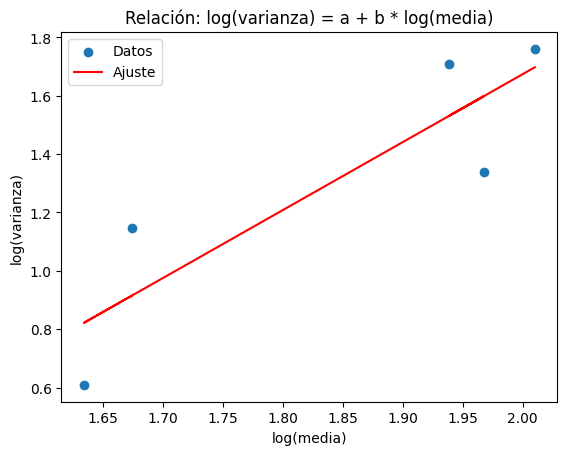

In [5]:
import numpy as np
from utils.regresiones import estimar_bethas

# Tomo log de la media y varianza
x, y = np.log(medias), np.log(varianzas)

# Ahora tengo una relación de la forma log(varianza) = a + b * log(media), estimo a y b para conocer el grado de la relación
x_intercepto = np.column_stack((np.ones_like(x), x))
b0, b1 = estimar_bethas(x_intercepto, y)
print(f'Intercepto: {b0}, Pendiente: {b1}')

# Ahora hago un gráfico que muestre la recta ajustada y los puntos
plt.scatter(x, y, label='Datos')
plt.plot(x, b0 + b1 * x, color='red', label='Ajuste')
plt.title('Relación: log(varianza) = a + b * log(media)')
plt.xlabel('log(media)')
plt.ylabel('log(varianza)')
plt.legend()
plt.show()

Podemos ver que el valor de la pendiente es apróximadamente 2.32, lo cual a efectos prácticos podría interpretarse **como un grado 2 en la relación media - varianza**.

Por lo tanto la distribución más adecuada para asignarle a la variable respuesta "Number", que representa a la cantidad de bloques usados para construir la torre, es la distribución **binomial negativa**, ya que además de contar con un grado 2 en su relación media-varianza, esta solo devuelve números naturales, lo cual es ídeal para modelar cantidades como en este caso.

## b)
Ajustar este MLG, es decir, encontrar estimaciones puntuales para los parámetros de regresión 𝛽.

### Desarrollo

In [6]:
import statsmodels.api as sm

# Armo la matriz de diseño 
X = df_torres['Age']
interceptos = np.ones(X.shape)
X_intercepto = np.column_stack((interceptos, X))

# Armo la variable objetivo
Y = df_torres['Number']

# Definir la familia de distribución como Binomial Negativa
neg_binom_family = sm.families.NegativeBinomial()

# Crear el modelo GLM
model = sm.GLM(Y, X, family=neg_binom_family)

# Ajustar el modelo
result = model.fit()

# Ver los resultados del ajuste
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Number   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -300.99
Date:                Wed, 18 Sep 2024   Deviance:                       12.839
Time:                        21:38:36   Pearson chi2:                     14.7
No. Iterations:                     5   Pseudo R-squ. (CS):           -0.04101
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.4685      0.026     17.967      0.0

c:\Users\gerar\OneDrive\Documentos\Mis Archivos\Estadistica e Inferencia\estat_inferencia\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
